# Triangle Meshes

This notebook demonstrates the application of `circle_bundles` to a synthetic dataset of 3D densities constructed from ...


In [1]:
# ============================================================
# Core scientific stack
# ============================================================
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# circle_bundles core API
# ============================================================
import circle_bundles as cb


In [2]:
def sample_o3(n: int, *, rng: np.random.Generator | None = None) -> np.ndarray:
    """
    Sample n random elements of O(3) uniformly (Haar measure).

    Returns
    -------
    mats_flat : (n,9) ndarray
        Each row is a flattened 3x3 orthogonal matrix.
        About half will have det=+1 (SO(3)), half det=-1 (reflections).
    """
    if rng is None:
        rng = np.random.default_rng()

    mats = np.empty((n, 3, 3), dtype=float)

    for i in range(n):
        # --- Step 1: random SO(3) via QR decomposition ---
        A = rng.normal(size=(3, 3))
        Q, R = np.linalg.qr(A)

        # Fix sign to ensure det(Q)=+1
        if np.linalg.det(Q) < 0:
            Q[:, 0] *= -1

        # --- Step 2: randomly reflect with prob 1/2 ---
        if rng.random() < 0.5:
            # reflect across a random axis (simple: flip one column)
            j = rng.integers(0, 3)
            Q[:, j] *= -1   # now det = -1

        mats[i] = Q

    return mats.reshape(n, 9)


In [3]:
import os
import trimesh
from PIL import Image
from typing import Callable, Tuple
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def load_obj_as_trimesh(
    obj_path: str,
    *,
    process: bool = False,
    merge_scene: bool = True,
    apply_default_rotation: bool = False,
    rotation_matrix: np.ndarray | None = None,
) -> trimesh.Trimesh:
    """
    Load an .obj (and its .mtl if referenced) into a single trimesh.Trimesh.

    Optional:
    - apply_default_rotation=True applies R = Rz(pi/2) @ Rx(pi/2)
      to the returned mesh vertices.
    - rotation_matrix lets you provide a custom 3x3 rotation (overrides default).

    Notes
    -----
    - If OBJ loads as a Scene, we concatenate all geometries (keeping transforms).
    - Rotation is applied AFTER merging, to the final returned mesh.
    """
    obj_path = os.fspath(obj_path)
    loaded = trimesh.load(obj_path, process=process)

    # ---- normalize into a single Trimesh ----
    if isinstance(loaded, trimesh.Trimesh):
        mesh = loaded
    elif isinstance(loaded, trimesh.Scene):
        if not merge_scene:
            raise ValueError("OBJ loaded as a Scene. Set merge_scene=True or handle the Scene yourself.")

        meshes = []
        for name, geom in loaded.geometry.items():
            T = np.eye(4)
            try:
                T = loaded.graph.get(name)[0]
            except Exception:
                pass
            g = geom.copy()
            g.apply_transform(T)
            meshes.append(g)

        if not meshes:
            raise ValueError(f"No geometry found in OBJ scene: {obj_path}")

        mesh = trimesh.util.concatenate(meshes)
    else:
        raise TypeError(f"Unsupported trimesh load type: {type(loaded)}")

    if not isinstance(mesh, trimesh.Trimesh):
        raise TypeError(f"Expected Trimesh, got {type(mesh)}")

    # ---- optional rotation ----
    if rotation_matrix is not None or apply_default_rotation:
        if rotation_matrix is None:
            # R = Rz(pi/2) @ Rx(pi/2)
            c = 0.0
            s = 1.0
            Rx = np.array([[1.0, 0.0, 0.0],
                           [0.0,  c,  -s],
                           [0.0,  s,   c]], dtype=float)  # pi/2
            Rz = np.array([[ c,  -s, 0.0],
                           [ s,   c, 0.0],
                           [0.0, 0.0, 1.0]], dtype=float)  # pi/2
            R = Rz @ Rx
        else:
            R = np.asarray(rotation_matrix, dtype=float)
            if R.shape != (3, 3):
                raise ValueError(f"rotation_matrix must be (3,3). Got {R.shape}.")

        Trot = np.eye(4, dtype=float)
        Trot[:3, :3] = R
        mesh = mesh.copy()
        mesh.apply_transform(Trot)

    return mesh


def mesh_vertex_normals(
    X: np.ndarray,
    *,
    n_vertices: int | None = None,
    vertex_dim: int = 3,
    idx: tuple[int, int, int] = (0, 1, 2),
    eps: float = 1e-12,
) -> np.ndarray:
    """
    Compute the oriented unit normal determined by three vertices
    from flattened mesh-vertex data.

    Raises a ValueError if any triple is colinear or degenerate.

    Parameters
    ----------
    X:
        Shape (D,) for one mesh or (N, D) for batch.
    n_vertices:
        Optional expected vertex count.
    vertex_dim:
        Usually 3.
    idx:
        (i, j, k) vertex indices used.
        Orientation follows cross(vj-vi, vk-vi).
    eps:
        Tolerance for detecting degeneracy.

    Returns
    -------
    normals:
        Shape (3,) or (N,3) of unit normals.
    """
    X = np.asarray(X)
    single = (X.ndim == 1)

    if single:
        Xb = X[None, :]
    elif X.ndim == 2:
        Xb = X
    else:
        raise ValueError(f"X must be 1D or 2D. Got shape {X.shape}.")

    N, D = Xb.shape

    if D % vertex_dim != 0:
        raise ValueError(f"D={D} not divisible by vertex_dim={vertex_dim}.")

    nv = D // vertex_dim
    if n_vertices is not None and nv != int(n_vertices):
        raise ValueError(f"Expected {n_vertices} vertices, got {nv}.")

    i, j, k = map(int, idx)
    if not (0 <= i < nv and 0 <= j < nv and 0 <= k < nv):
        raise ValueError(f"indices {idx} out of range for nv={nv}")

    V = Xb.reshape(N, nv, vertex_dim)

    a = V[:, i]
    b = V[:, j]
    c = V[:, k]

    u = b - a
    v = c - a

    n = np.cross(u, v)
    norm = np.linalg.norm(n, axis=1)

    # Strict check
    bad = norm <= eps
    if np.any(bad):
        inds = np.where(bad)[0]
        raise ValueError(
            f"Colinear or degenerate vertex triples encountered at indices: {inds[:10]}"
            + (" ..." if len(inds) > 10 else "")
        )

    normals = n / norm[:, None]

    if single:
        return normals[0]
    return normals



def bake_face_rgba_from_texturevisuals(
    mesh,
    *,
    method: str = "mean_corners",  # "mean_corners" or "center"
    flip_v: bool = True,
    default_rgba=(0.65, 0.70, 0.80, 1.0),
) -> np.ndarray:
    """
    Bake per-face RGBA colors in [0,1] from a trimesh with TextureVisuals.

    Your case: mesh.visual is TextureVisuals, has uv=True, face_uvs=False, material.image=True.
    This implementation assumes uv is per-vertex (len(uv) == n_vertices), so face UV corners
    are mesh.faces indexing into uv.

    Parameters
    ----------
    method:
        - "mean_corners": sample texture at the 3 triangle corners and average.
        - "center": sample at triangle UV centroid (often smoother).
    flip_v:
        If True, converts UV v-coordinate to image y by y = (1 - v)*(H-1). Common convention.
    default_rgba:
        Used if anything is missing.

    Returns
    -------
    rgba:
        (F,4) float32 array with values in [0,1].
    """
    faces = np.asarray(mesh.faces, dtype=np.int64)
    F = faces.shape[0]
    V = np.asarray(mesh.vertices).shape[0]

    vis = getattr(mesh, "visual", None)
    if vis is None or not hasattr(vis, "uv"):
        return np.tile(np.array(default_rgba, float), (F, 1)).astype(np.float32)

    uv = np.asarray(vis.uv, dtype=np.float64)  # expected (V,2) in your case
    if uv.ndim != 2 or uv.shape[1] != 2:
        return np.tile(np.array(default_rgba, float), (F, 1)).astype(np.float32)

    if uv.shape[0] != V:
        raise ValueError(
            f"Expected per-vertex UVs with shape ({V},2), got {uv.shape}. "
            "If your OBJ uses a separate UV index stream, we can handle it, but this file doesn't look like that."
        )

    material = getattr(vis, "material", None)
    img = getattr(material, "image", None) if material is not None else None
    if img is None:
        return np.tile(np.array(default_rgba, float), (F, 1)).astype(np.float32)

    if isinstance(img, Image.Image):
        tex = np.asarray(img.convert("RGBA"), dtype=np.uint8)  # (H,W,4)
    else:
        tex = np.asarray(img, dtype=np.uint8)
        if tex.ndim == 3 and tex.shape[2] == 3:
            alpha = 255 * np.ones((tex.shape[0], tex.shape[1], 1), dtype=np.uint8)
            tex = np.concatenate([tex, alpha], axis=2)
        if tex.ndim != 3 or tex.shape[2] != 4:
            return np.tile(np.array(default_rgba, float), (F, 1)).astype(np.float32)

    H, W = tex.shape[:2]

    # UVs at face corners: (F,3,2)
    uv_tri = uv[faces]

    if method == "center":
        uv_samp = uv_tri.mean(axis=1)  # (F,2)
    elif method == "mean_corners":
        uv_samp = uv_tri.reshape(-1, 2)  # (F*3,2)
    else:
        raise ValueError("method must be 'mean_corners' or 'center'.")

    u = np.clip(uv_samp[:, 0], 0.0, 1.0)
    v = np.clip(uv_samp[:, 1], 0.0, 1.0)

    x = np.round(u * (W - 1)).astype(np.int64)
    if flip_v:
        y = np.round((1.0 - v) * (H - 1)).astype(np.int64)
    else:
        y = np.round(v * (H - 1)).astype(np.int64)

    rgba = tex[y, x].astype(np.float32) / 255.0  # (F,4) if center; (F*3,4) if corners

    if method == "center":
        face_rgba = rgba
    else:
        face_rgba = rgba.reshape(F, 3, 4).mean(axis=1)

    return face_rgba.astype(np.float32)



def make_meshy_visualizer(
    mesh,
    *,
    edge_color: str = "none",
    alpha: float = 1.0,
    bake_method: str = "center",
    figsize: Tuple[float, float] = (5.0, 5.0),
    dpi: int = 150,
    elev: float = 10.0,
    azim: float = 20.0,
    linewidth: float = 0.0,
    show_axes: bool = False,
    axes_scale: float = 0.3,   # fraction of mesh size
    axes_lw: float = 2.0,
):
    faces = np.asarray(mesh.faces, dtype=int)
    V = int(np.asarray(mesh.vertices).shape[0])

    # Bake ONCE from template mesh
    face_rgba = bake_face_rgba_from_texturevisuals(mesh, method=bake_method)

    def vis_func(flat_mesh: np.ndarray) -> Figure:
        flat_mesh = np.asarray(flat_mesh, dtype=float)
        if flat_mesh.shape != (3 * V,):
            raise ValueError(f"Expected flat_mesh shape {(3*V,)}, got {flat_mesh.shape}")

        verts = flat_mesh.reshape((V, 3))
        tris = verts[faces]

        fig = plt.figure(figsize=figsize, dpi=dpi, facecolor="none")
        ax = fig.add_subplot(111, projection="3d", facecolor="none")
        ax.set_axis_off()

        poly = Poly3DCollection(
            tris,
            facecolors=face_rgba,
            edgecolor=edge_color,
            alpha=float(alpha),
            linewidths=float(linewidth),
        )
        ax.add_collection3d(poly)

        # -------- scaling / limits --------
        max_range = float(np.ptp(verts, axis=0).max() + 1e-12)
        mid = verts.mean(axis=0)

        lims = [(float(m - max_range / 2), float(m + max_range / 2)) for m in mid]
        ax.set_xlim(*lims[0])
        ax.set_ylim(*lims[1])
        ax.set_zlim(*lims[2])
        ax.set_box_aspect([1, 1, 1])

        # -------- optional axes --------
        if show_axes:
            L = axes_scale * max_range
            x0, y0, z0 = mid

            # X axis (red)
            ax.plot(
                [x0, x0 + L], [y0, y0], [z0, z0],
                color="red", linewidth=axes_lw
            )

            # Y axis (green)
            ax.plot(
                [x0, x0], [y0, y0 + L], [z0, z0],
                color="green", linewidth=axes_lw
            )

            # Z axis (blue)
            ax.plot(
                [x0, x0], [y0, y0], [z0, z0 + L],
                color="blue", linewidth=axes_lw
            )

        ax.view_init(elev=float(elev), azim=float(azim))
        return fig

    return vis_func



def rotation_from_unit_a_to_unit_b(a: np.ndarray, b: np.ndarray, *, eps: float = 1e-12) -> np.ndarray:
    """
    Return a 3x3 rotation matrix R (det=+1) such that R @ a = b,
    where a and b are (approximately) unit vectors in R^3.

    Robustly handles:
    - a ≈ b  -> identity
    - a ≈ -b -> 180° rotation about any axis orthogonal to a

    Parameters
    ----------
    a, b : array-like shape (3,)
        Unit vectors (we will normalize defensively).
    eps : float
        Tolerance.

    Returns
    -------
    R : (3,3) ndarray
    """
    a = np.asarray(a, dtype=float).reshape(3)
    b = np.asarray(b, dtype=float).reshape(3)

    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na <= eps or nb <= eps:
        raise ValueError("a and b must be nonzero vectors.")
    a = a / na
    b = b / nb

    c = float(np.dot(a, b))  # cos(theta)

    # If a and b are (almost) the same
    if c > 1.0 - 1e-10:
        return np.eye(3, dtype=float)

    # If a and b are (almost) opposite
    if c < -1.0 + 1e-10:
        # Pick any unit vector u orthogonal to a, then rotate 180° about u:
        # R = -I + 2 u u^T
        # Choose u by crossing a with a basis vector not parallel to a.
        basis = np.array([1.0, 0.0, 0.0])
        if abs(a[0]) > 0.9:
            basis = np.array([0.0, 1.0, 0.0])
        u = np.cross(a, basis)
        nu = np.linalg.norm(u)
        if nu <= eps:
            # Extremely unlikely, but just in case
            basis = np.array([0.0, 0.0, 1.0])
            u = np.cross(a, basis)
            nu = np.linalg.norm(u)
            if nu <= eps:
                raise RuntimeError("Failed to find an orthogonal axis for 180° rotation.")
        u = u / nu
        return (-np.eye(3) + 2.0 * np.outer(u, u)).astype(float)

    # General case: Rodrigues' rotation formula
    v = np.cross(a, b)
    s = np.linalg.norm(v)  # sin(theta), >0 here
    vx = np.array([
        [0.0,    -v[2],  v[1]],
        [v[2],   0.0,   -v[0]],
        [-v[1],  v[0],   0.0],
    ], dtype=float)

    R = np.eye(3) + vx + (vx @ vx) * ((1.0 - c) / (s * s))
    return R.astype(float)



def projected_normals_from_flat_vertices(
    X: np.ndarray,
    *,
    n_vertices: int | None = None,
    idx: tuple[int, int, int] = (0, 1, 2),
    eps: float = 1e-12,
    reference_unit_normal: np.ndarray | None = None,
) -> np.ndarray:
    """
    Compute oriented unit normals from flattened mesh-vertex data, optionally
    recalibrated by a reference unit vector.

    - Base projection: n(x) = unit( (v_j - v_i) x (v_k - v_i) )
    - If reference_unit_normal = v is provided:
        Let e1 = (1,0,0).
        Compute Q so that Q v = e1.
        Return Q n(x) for each sample.

    Parameters
    ----------
    X : (D,) or (N,D)
        Flattened vertices. D = 3 * n_vertices.
    n_vertices : int, optional
        Validate expected vertex count.
    idx : (i,j,k)
        Vertex indices used.
    eps : float
        Degeneracy tolerance.
    reference_unit_normal : (3,) array-like, optional
        Unit vector v that represents the template mesh's computed normal
        which should be treated as pointing along +x.

    Returns
    -------
    normals : (3,) or (N,3)
        Unit normals (recalibrated if requested).
    """
    X = np.asarray(X)
    single = (X.ndim == 1)
    if single:
        Xb = X[None, :]
    elif X.ndim == 2:
        Xb = X
    else:
        raise ValueError(f"X must be 1D or 2D. Got shape {X.shape}.")

    N, D = Xb.shape
    if D % 3 != 0:
        raise ValueError(f"Flattened dimension D={D} is not divisible by 3.")
    nv = D // 3
    if n_vertices is not None and int(n_vertices) != nv:
        raise ValueError(f"Expected n_vertices={n_vertices}, inferred {nv} from D={D}.")

    i, j, k = map(int, idx)
    if not (0 <= i < nv and 0 <= j < nv and 0 <= k < nv):
        raise ValueError(f"idx={idx} out of range for nv={nv}.")

    V = Xb.reshape(N, nv, 3)
    a = V[:, i, :]
    b = V[:, j, :]
    c = V[:, k, :]

    u = b - a
    v = c - a
    n = np.cross(u, v)
    norm = np.linalg.norm(n, axis=1)

    bad = norm <= eps
    if np.any(bad):
        inds = np.where(bad)[0]
        raise ValueError(
            f"Colinear/degenerate vertex triples at indices: {inds[:10]}"
            + (" ..." if len(inds) > 10 else "")
        )

    normals = n / norm[:, None]  # (N,3)

    # Optional recalibration
    if reference_unit_normal is not None:
        ref = np.asarray(reference_unit_normal, dtype=float).reshape(3)
        e1 = np.array([1.0, 0.0, 0.0], dtype=float)
        Q = rotation_from_unit_a_to_unit_b(ref, e1, eps=eps)  # Q @ ref = e1
        normals = normals @ Q.T  # apply Q to each normal (row vectors)

    if single:
        return normals[0]
    return normals



def get_calibrated_mesh_projection(
    template_mesh,
    *,
    idx: tuple[int, int, int] = (0, 1, 2),
    target_axis: np.ndarray = np.array([1.0, 0.0, 0.0]),
    eps: float = 1e-12,
):
    """
    Create a projection function that maps flattened mesh-vertex data to
    recalibrated oriented unit normals.

    Recalibration is chosen so that the template mesh's normal (computed from idx)
    gets mapped to `target_axis` (default: (1,0,0)).

    Returns
    -------
    proj(X) -> normals
        X can be shape (D,) or (N,D) where D = 3*V for the template mesh.
        Output is shape (3,) or (N,3).
    """

    # ---- basic template info ----
    verts0 = np.asarray(template_mesh.vertices, dtype=float)
    V = int(verts0.shape[0])
    i, j, k = map(int, idx)
    if not (0 <= i < V and 0 <= j < V and 0 <= k < V):
        raise ValueError(f"idx={idx} out of range for template with V={V} vertices.")

    # ---- compute template normal v (strict) ----
    a = verts0[i]
    b = verts0[j]
    c = verts0[k]
    n0 = np.cross(b - a, c - a)
    n0_norm = float(np.linalg.norm(n0))
    if n0_norm <= eps:
        raise ValueError(
            "Template vertex triple is colinear/degenerate; cannot define reference normal."
        )
    v_ref = n0 / n0_norm  # unit

    # ---- compute calibration rotation Q so that Q @ v_ref = target_axis ----
    target_axis = np.asarray(target_axis, dtype=float).reshape(3)
    Q = rotation_from_unit_a_to_unit_b(v_ref, target_axis, eps=eps)

    def proj(X: np.ndarray) -> np.ndarray:
        """
        Compute oriented unit normals from X (flattened vertices) and recalibrate via Q.
        """
        normals = projected_normals_from_flat_vertices(
            X,
            n_vertices=V,
            idx=idx,
            eps=eps,
            reference_unit_normal=None,  # we'll apply Q ourselves (faster; avoids recomputing)
        )

        # normals might be (3,) or (N,3)
        if normals.ndim == 1:
            return Q @ normals
        return normals @ Q.T

    # Expose a couple helpful attributes
    proj.n_vertices = V
    proj.idx = idx
    proj.reference_normal = v_ref
    proj.calibration_rotation = Q

    return proj


(29751,)


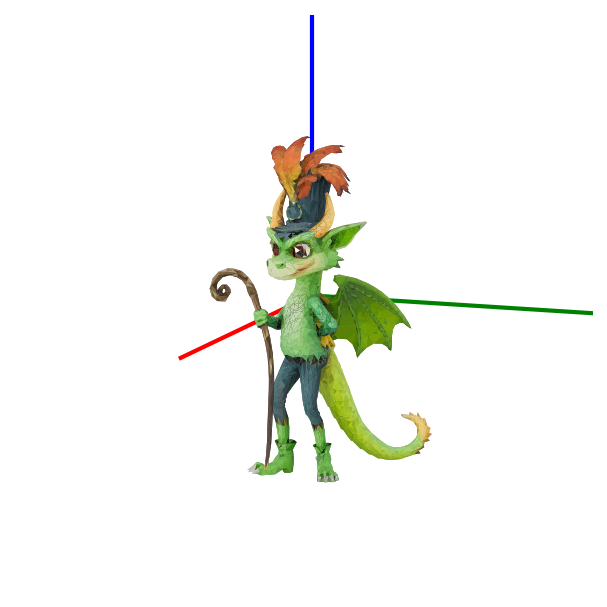

In [4]:
file_path = '/Users/bradturow/Desktop/Meshes/Meshy_AI_An_adorable_furry_dra_0131233424_texture_obj/Meshy_AI_An_adorable_furry_dra_0131233424_texture.obj'
mesh = load_obj_as_trimesh(file_path, process=False, merge_scene=True, apply_default_rotation = True)

x0 = np.asarray(mesh.vertices, dtype=float).reshape(-1)  # (3V,)
print(x0.shape)


vis_func = make_meshy_visualizer(mesh, show_axes = True, axes_scale = 1)
fig = vis_func(x0)
plt.show()

First, generate a dataset of triangle meshes, stored as vectors of length $3\times 6 = 18$:

In [8]:
#Create the template triangle mesh
#mesh = cb.make_star_pyramid(n_points = 5, height = 1)
mesh, face_groups = cb.make_tri_prism(height=5, radius=1)

#Create a visualization function
#vis_func = cb.make_star_pyramid_visualizer(mesh)
vis_func = cb.make_tri_prism_visualizer(mesh, face_groups)


In [11]:
n_samples = 5000
rng = np.random.default_rng(0)
#so3_data = cb.sample_so3(n_samples, rng=rng)[0]
o3_data = sample_o3(n_samples, rng = rng)
data = cb.get_mesh_sample(mesh, o3_data)

In [ ]:
#Create a projection map for the data
mesh_proj = get_calibrated_mesh_projection(mesh)

View a small sample of the dataset:

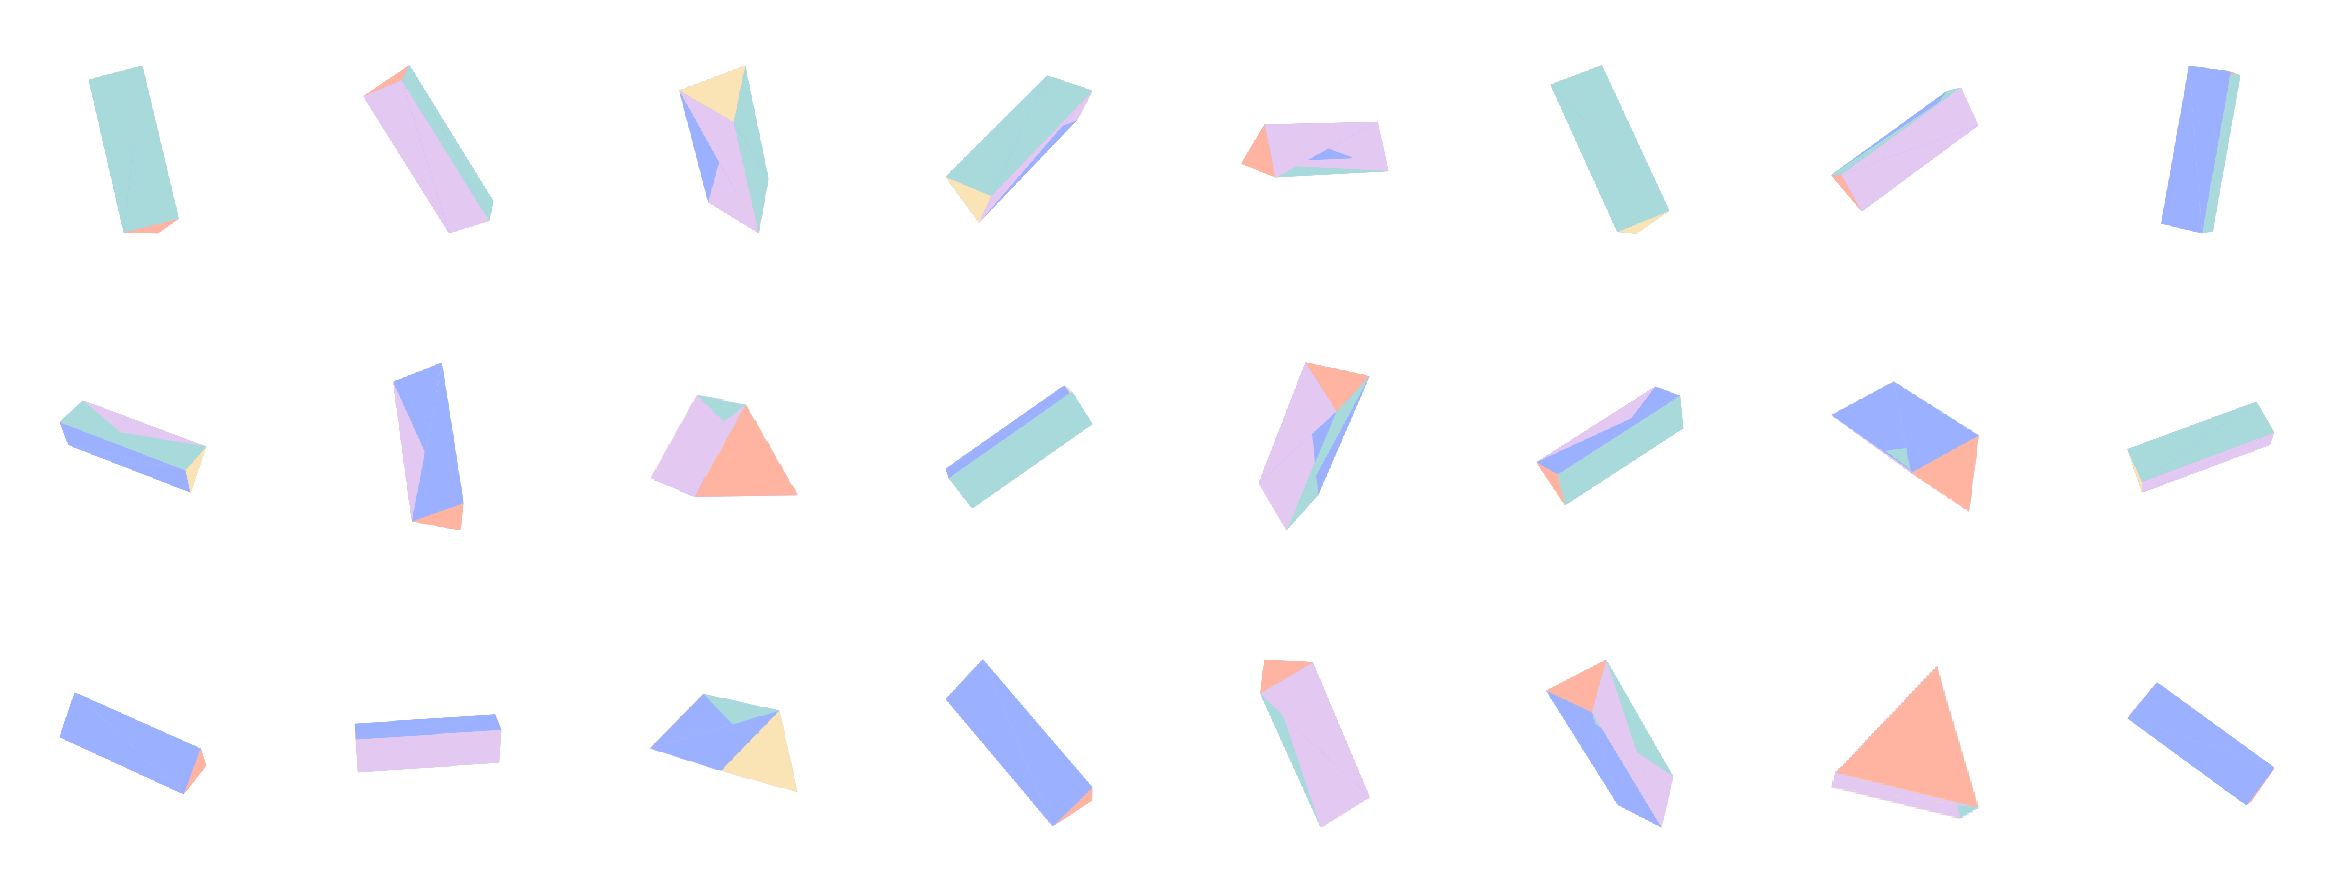

In [12]:
fig = cb.show_data_vis(
    data, 
    vis_func, 
    max_samples=24, 
    n_cols=8, 
#    sampling_method="first", 
    pad_frac=0.3)
plt.show()


Compute the base projections to $\mathbb{S}^{2}$:

In [ ]:
base_points = mesh_vertex_normals(data)

Construct an open cover of $\mathbb{S}^{2}$ using a collection of nearly equidistant landmark points (see reference section):

In [ ]:
n_landmarks = 60
cover = cb.make_s2_fibonacci_star_cover(base_points, n_vertices = n_landmarks)

summ = cover.summarize(plot = True)

Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [ ]:
fig = cover.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$

In [ ]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [4,25,56], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Optionally run the cell below to show a visualization of an interactive visualization of the projection map:

In [ ]:
app = cb.show_bundle_vis(base_points = base_points, data = data)

Compute local circular coordinates, approximate transition matrices and characteristic clases

In [ ]:
import numpy as np

def check_O3_mats(mats_flat: np.ndarray, *, atol: float = 1e-6):
    M = mats_flat.reshape(-1, 3, 3)
    n = M.shape[0]
    I = np.eye(3)

    ortho_err = np.linalg.norm(M.transpose(0,2,1) @ M - I, axis=(1,2))
    dets = np.linalg.det(M)

    print("n:", n)
    print("orthogonality: max err", ortho_err.max(), "mean err", ortho_err.mean())
    print("det: min", dets.min(), "max", dets.max())
    print("fraction det<0:", np.mean(dets < 0))
    print("fraction |det-1|<atol:", np.mean(np.abs(dets - 1) < 1e-5))
    print("fraction |det+1|<atol:", np.mean(np.abs(dets + 1) < 1e-5))

    if not (ortho_err.max() < 1e-3):
        print("WARNING: orthogonality looks off—sampler or dtype issue?")
    if not (0.3 < np.mean(dets < 0) < 0.7):
        print("WARNING: det split not ~50/50—reflection step might be wrong.")


In [ ]:
check_O3_mats(o3_data)

In [ ]:
bundle = cb.build_bundle(
    data,
    cover,
    show=True,                          
)


Now, restrict the bundle to the equator $\mathbb{S}^{1}\subset \mathbb{S}^{2}$:

In [ ]:
eps = 0.15  # thickness of equatorial band (in the chosen S^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.data[eq_mask]

# Parametrize the equator by an angle in S^1 
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % (2*np.pi)

print(f"Equator band: {eq_data.shape[0]} / {bundle.data.shape[0]} samples (eps={eps}).")

Constuct an open cover of $\mathbb{S}^{1}$ by metric balls around equally-spaced landmark points:

In [ ]:
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi, n_landmarks, endpoint=False)

overlap = 1.5
radius = overlap * np.pi / n_landmarks

eq_cover = cb.MetricBallCover(
    eq_base_angles,
    landmarks,
    radius,
    metric=cb.S1AngleMetric(),
)
eq_cover_data = eq_cover.build()

#Show a summary of the construction
eq_summ = eq_cover.summarize(plot = True)

Compute characteristic classes for the restricted bundle:

In [ ]:
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    show=True,
)


Observe that the restricted bundle is orientable, hence trivial, as expected. Construct a global toroidal coordinate system by synchronizing local circular coordinates:

In [ ]:
eq_triv_result = eq_bundle.get_global_trivialization()

Finally, show a visualization of the coordinatized meshes:

In [ ]:
coords = np.column_stack([eq_base_angles, eq_triv_result.F])

fig = cb.lattice_vis(
    eq_data,
    coords,
    vis_func,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=100,
    dpi=200,
)

plt.show()


Base projection angle varies from $0$ to $2\pi$ along the $x$-direction and fiber angle varies from $0$ to $2\pi$ along the $y$-direction.  Notice that base projection roughly corresponds to axis of symmetry, as expected.  The coordinatized meshes in each column approximately traverse a full rotation about the axis of symmetry. Meshes on opposite edges of the diagram roughly correspond, reflecting the toroidal topology of the restricted dataset. 